# 3d plots from html tables

lets use html and html to try to make a 3d plot.

In [1]:
%%

    shell.environment.globals.update(vars(__builtins__))

In [2]:
%%
## making sample data

create some randomized datasets with distinct clusters

    import sklearn.datasets, sklearn.discriminant_analysis, sklearn.model_selection
    features = 6
    df = pandas.DataFrame(*sklearn.datasets.make_blobs(200, features, centers=[
        (i**2,)*features for i in range(features)
    ]))

    df = pandas.concat(dict(zip("test train".split(), sklearn.model_selection.train_test_split(df))))
    df = df.rename_axis(index="selection blob".split())

apply statistical analysis to reduce the dimensionality of the data.
a sample of the full and reduced dataset are shown next, with the source as a caption.

<figure>
{{df.sample(2).style.to_html()}}
<figcaption>

    model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
    model.fit(df.loc["test"], df.loc["test"].index)
    df = df.combine_first(
        pandas.DataFrame(model.transform(df.values), columns=list("xyz"), index=df.index)
    )
    df = pandas.concat([df, pandas.DataFrame([[-1]*features+ [0,0,0]] , pandas.MultiIndex.from_tuples([("test", -1)]), df.columns)])

</figcaption></figure>

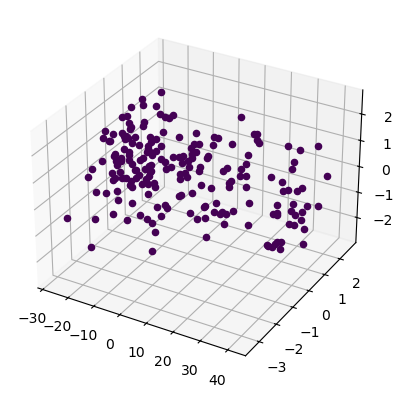

In [3]:
%%
## generate a 3d plot in an image for comparsion

we'll compare our interactive css outcomes with rendered html image.

    import matplotlib.pyplot
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(projection="3d")
    df[list("xyz")].apply(lambda x: ax.scatter(*x.values, c=x.name[1]), axis=1);

In [4]:
%%
## creating our table
    
{% set format="%.2f" %}
<table id=pca>
    <tbody style="--x-min: {{df.x.min()}}; --x-max: {{df.x.max()}}; --y-min: {{df.y.min()}}; --y-max: {{df.y.max()}}; 
    --z-min: {{df.z.min()}}; --z-max: {{df.z.max()}};">
    {%- for i, (_, row) in enumerate(df.iterrows()) -%}
        <tr style="--x: {{row.loc['x']}}; --y: {{row.loc['y']}}; --z: {{row.loc['z']}};">
        <th>{{i}}</th>
        {%- for j in range(features) -%}
        <td>{{format % row.loc[j]}}</td>
        {%- endfor %}{% for j in "xyz" -%}
        <td hidden>{{ row.loc[j]}}</td>
        {%- endfor %}</tr>
    {%- endfor %}</tbody>
</table>


<form name=controls>
    <script>
    function rotate(axis, el){
        document.getElementById("pca").style.setProperty(`--rotate-${axis}`, `${el.value}deg`);
    }
    </script>
    <label>x
    <input type=range min=0 max=360 value=350 step=5 oninput="rotate('x', this)" name="x"/>
    </label>
    <label>y
    <input type=range min=0 max=360 value=5 step=5 oninput="rotate('y', this)" name="y"/>
    </label>
    <label>z
    <input type=range min=0 max=360 value=15 step=5 oninput="rotate('z', this)" name="z"/>
    </label>
    <label>show table<input type=checkbox name=show checked onchange="document.getElementById('pca-style').setAttribute('media', this.checked ? 'screen': 'none')"/></label>
</form>

0,8.83,9.24,11.70,7.80,9.00,9.70,-0.6635029008392411,-1.9012911652323758,-1.7368236800201728
1,-1.40,0.56,0.69,1.35,0.27,0.27,-23.998494749551067,-0.8372066739043091,1.178781464407595
2,9.20,11.70,8.59,9.43,9.24,7.84,-1.0723415006797057,-1.3026389148367665,1.3680768928370817
3,9.18,9.67,9.53,6.90,8.63,9.24,-1.8846424519981408,-1.7137440524402119,-0.8212229953216273
4,6.94,9.05,7.87,9.73,7.68,10.20,-2.3370734773822974,-1.1246715184700806,1.7180074217604853
5,4.55,4.85,3.77,6.33,5.06,2.90,-13.18157543302989,1.1413798272183662,1.3880551128671494
6,24.56,24.42,24.95,26.03,23.52,25.78,39.39436265421904,-0.08956661020480447,-0.09596896240290306
7,17.05,15.17,15.42,16.46,15.13,17.32,17.01550230062591,0.8591938798873224,-0.38414357928627824
8,1.48,-0.73,0.59,-0.54,0.96,-0.35,-24.059533363507096,1.0636139596284921,-0.9661314727294197
9,16.19,17.07,16.31,15.97,15.58,14.47,15.87595464920856,-0.7275453213835715,-0.12387355883859186
10,-0.21,-0.02,-1.20,0.28,-0.67,0.74,-24.9125793488874,-0.029689896706497895,0.993167816383191


In [5]:
%%
## styling the table

style the table using 3d css transform, rotations, and translations.

    display\
```html
<style id=pca-style media=screen>
.jp-RenderedHTMLCommon tbody tr:hover {
    background: unset;
}
#pca {
    --height: 600px;
    --width: 600px;
    --depth: 600px;
    --rotate-x: 350deg;
    --rotate-y: 5deg;
    --rotate-z: 15deg;
    transform-style: preserve-3d;
    display: block;
    position: relative;
    width: var(--width);
    height: var(--height);
    tbody{
        border: solid;
        position: absolute;
        display: block;
        top: 0;
        left: 0;
        width: 100%;
        height: 100%;    
        --dx: calc(var(--x-max) - var(--x-min));
        --dy: calc(var(--y-max) - var(--y-min));
        --dz: calc(var(--z-max) - var(--z-min));
    }
    tr {
        filter: invert(100%);
        position: absolute;
        display: block;
        top: calc((var(--y-max) - var(--y)) / var(--dy) * var(--height));
        left: calc(( var(--x) - var(--x-min)) / var(--dx) * var(--width));
        transform-origin: 
                calc( -1 * var(--x) / var(--dx) *  var(--width))
                calc( var(--y) / var(--dy) *  var(--height)) calc( -1 * var(--z) / var(--dz) * var(--depth));
        transform: 
            translateZ(calc(var(--z) / var(--dz) * var(--depth)))
            rotateX(var(--rotate-x)) rotateY(var(--rotate-y)) rotateZ(var(--rotate-z));
        th {
            display: block;
            border-radius: 100%;
        }
        td {
            display: none;
        }
        z-index: 0;
    }
    tr:hover, tr:focus-within {
        th, td:not([hidden]) {
            display: inline-block;
            overflow: unset;
            filter: invert(0%);
            background: rgba(0,0,0,.9);
            z-index: 9999;
        }
    }
    tr:last-of-type {
        filter: invert(0%);
        background-color: red;
    }
}
</style>
```